In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E01484.mat
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E07438.hea
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E07146.hea
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E02870.mat
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E05997.hea
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E10169.mat
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E09336.mat
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E09806.hea
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E07940.mat
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E04668.mat
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E01567.hea
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E03430.mat
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E00543.hea
/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB/E01553.hea
/kaggle/input/georgia-12lead-ecg-challenge-datab

In [2]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from keras.optimizers import Adam


2024-05-20 07:37:19.974521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 07:37:19.974658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 07:37:20.129223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set directory
os.chdir('/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB')

def read_data_using_scipy(directory):
    signal = loadmat(directory)['val'][0]
    return signal

def read_file_using_scipy(directory):
    signal = loadmat(directory)['val'][0]
    return len(signal)

def label_loading(directory1):
    directory = directory1[:-4] + '.hea'
    with open(directory, 'r') as f:
        lines = f.readlines()
        dx = lines[15].split()
        dx = dx[1].split(',')
        dx = list(map(lambda x: np.int32(x), dx))
        return dx

def select_element_from_list(x):
    return x[0]


In [4]:
data_directory = os.listdir('/kaggle/input/georgia-12lead-ecg-challenge-database/WFDB')
data_directory = list(filter(lambda x: x.split('.')[1] == 'mat', data_directory))


In [5]:
x = list(map(read_file_using_scipy, data_directory))
x = np.array(x)

df = pd.DataFrame({'Data_Directory': data_directory, 'length': x})
print(df['length'].value_counts())
df = df[df['length'] == 5000]
df.reset_index(inplace=True, drop=True)


length
5000    10292
2500       52
Name: count, dtype: int64


In [6]:
df['Disease'] = df['Data_Directory'].apply(label_loading)
df['Number_of_Disease'] = df['Disease'].apply(len)

one_disease_only_data = df[df['Number_of_Disease'] == 1]
one_disease_only_data = one_disease_only_data.loc[:, 'Data_Directory':'Disease']
one_disease_only_data['Disease'] = one_disease_only_data['Disease'].apply(select_element_from_list)

summary_of_disease_dist = one_disease_only_data.groupby('Disease').count()['Data_Directory']
disease = summary_of_disease_dist.sort_values()[::-1][:6].index


In [7]:
Our_Final_dataset_Directory = pd.DataFrame()
for i in disease:
    group = one_disease_only_data.groupby('Disease').get_group(i)
    if i == 426783006:
        group.loc[:, 'Disease'] = 0
    else:
        group.loc[:, 'Disease'] = 1
    Our_Final_dataset_Directory = pd.concat([Our_Final_dataset_Directory, group])

Our_Final_dataset_Directory.reset_index(inplace=True, drop=True)
Our_Final_dataset_Directory = Our_Final_dataset_Directory.sample(frac=1, random_state=123, ignore_index=True).loc[:, ['Data_Directory', 'Disease']]


In [8]:
X = Our_Final_dataset_Directory['Data_Directory']
a = X.apply(read_data_using_scipy).values
Q = np.stack(a)
print(Q)


[[ 58  58  58 ... -92 -87 -97]
 [-29 -29 -29 ... -43 -43 -24]
 [126  73   9 ...  -4   9 -19]
 ...
 [-68 -68 -68 ... -78 -78 -92]
 [-58 -58 -58 ... 165 151 136]
 [-48 -48 -48 ... -14   0  14]]


In [9]:
y = Our_Final_dataset_Directory['Disease']
y = y.values

X_train, X_test, y_train, y_test = train_test_split(Q, y, test_size=0.2, random_state=42)


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(2412, 5000, 1)
(2412,)
(603, 5000, 1)
(603,)


In [11]:
model = Sequential()
model.add(Input(shape=(5000, 1)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=1, validation_data=(X_test, y_test))


76/76 ━━━━━━━━━━━━━━━━━━━━ 870s 11s/step - accuracy: 0.5461 - loss: 0.6897 - val_accuracy: 0.5887 - val_loss: 0.6780


19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step
[[0.43287477]
 [0.44121003]
 [0.42789048]
 [0.4337837 ]
 [0.4382512 ]
 [0.42957127]
 [0.43195933]
 [0.43260744]
 [0.44097206]
 [0.4314826 ]
 [0.42996934]
 [0.43237653]
 [0.41910127]
 [0.4381176 ]
 [0.43198854]
 [0.43140653]
 [0.44010058]
 [0.43298742]
 [0.44296598]
 [0.43198356]
 [0.43216228]
 [0.43382782]
 [0.43110737]
 [0.4323628 ]
 [0.4318029 ]
 [0.44180006]
 [0.42996517]
 [0.43185598]
 [0.4337263 ]
 [0.4323941 ]
 [0.42941138]
 [0.43202233]
 [0.43186587]
 [0.43247342]
 [0.421559  ]
 [0.42280623]
 [0.43161294]
 [0.4326402 ]
 [0.43740946]
 [0.4395777 ]
 [0.4335452 ]
 [0.4291278 ]
 [0.43302867]
 [0.43190548]
 [0.42931134]
 [0.42025742]
 [0.4311057 ]
 [0.42963573]
 [0.4319406 ]
 [0.43021804]
 [0.4330332 ]
 [0.4320978 ]
 [0.43280092]
 [0.4310347 ]
 [0.43234113]
 [0.432105  ]
 [0.43858668]
 [0.43267474]
 [0.43564585]
 [0.43221205]
 [0.43108273]
 [0.42867622]
 [0.43136317]
 [0.43271667]
 [0.41984195]
 [0.43069154]
 [0.43144903]
 [0.43628594]
 [0.42966

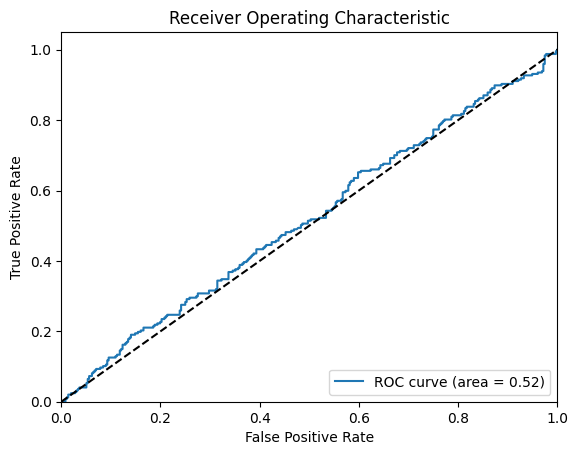

In [13]:
predictions = model.predict(X_test)
print(predictions)

roc_auc = roc_auc_score(y_test, predictions)
print('ROC AUC:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.metrics import confusion_matrix, roc_curve, auc
# Binarize predictions
binary_predictions = (predictions > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(

In [14]:
y_test, binary_predictions

Confusion Matrix:
[[355   1]
 [247   0]]


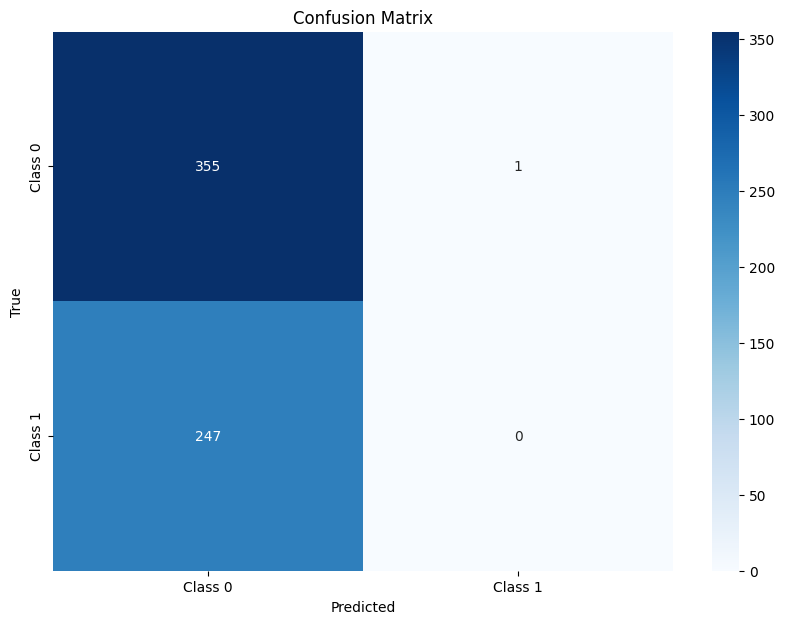

In [14]:
)
print('Confusion Matrix:')
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()